# Assessment of Urban Decay in Detroit City, Michigan

https://cybergisxhub.cigi.illinois.edu/notebook/ggis-407-final-project-urban-decay-in-detroit-city/

Three main aspects to portray urban decay:
1. Physical = vacant buildings
2. Demographic = population total and population by race
3. Socio-economic = unemployment rate and household income

## Content
- [1. Libraries](#libraries)
- [2. Data Preparation](#prep)
- [3. Analysis and Visualization](#viz)
    - [a. Total population](#pop)
    - [b. Population by Race](#race)
    - [c. Household Income](#income)
    - [d. Unemployment rate](#employ)
    - [e. Building vacancy](#vacant)
- [4. Regression Analysis](#reg)
- [5. Conclusion](#conclusion)

### 1. Libraries <a id="libraries"></a>

In [1]:
# import required libraries
%matplotlib inline
import os
import fiona

# pretty printing - makes some kinds of text output easier to read
import pprint
import IPython
from matplotlib import pyplot as plt

import pandas as pd
import geopandas as gpd
from pandas import Series
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
import contextily as ctx
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### 2. Data Preparation <a id="prep"></a>

The primary goal of this study is to detect the differences between the period before the Strategic Neighborhood Fund program in 2014 and after the program in 2022. Five variables for each year resulting ten datasets for variables. To avoid repetition some functions are created.

In [2]:
# create function to read multiple files
def read_files(filenames, names):
    dfs = []
    for filename, name in zip(filenames, names):
        try:
            df = gpd.read_file(filename)
            dfs.append((name,df))
        except FileNotFoundError:
            print(f"Error: File '{filename}' not found.")
        except Exception as e:
            print(f"Error: {e}")
    return dfs

In [3]:
# list files to be read and their output names
filenames = ['data_raw/18f98a29-473c-4598-a95f-90a6aa3a6e952020330-1-20bvlw.3fg7n.shp',
             'data_raw/Parcels.shp',
             'data_raw/pop_detroit_2014.csv',
             'data_raw/pop_detroit_2022.csv',
             'data_raw/race_detroit_2014.csv',
             'data_raw/race_detroit_2022.csv',
             'data_raw/income_detroit_2014.csv',
             'data_raw/income_detroit_2022.csv',
             'data_raw/employment_detroit_2014.csv',
             'data_raw/employment_detroit_2022.csv']
names = ['vacant2014','vacant2023','pop2014','pop2022',
            'race2014','race2022','income2014','income2022','employ2014','employ2022']
dataframes = read_files(filenames, names)

In [4]:
# Convert each tuple (name, DataFrame) from result into separate variables (individual DataFrames)
for name, df in dataframes:
    globals()[name] = df

In [5]:
# check files and columns
vacant2014.columns

Index(['OBJECTID', 'GEOID10', 'NAMELSAD10', 'SqMiles', 'Acres', 'CounciDist',
       'Likely_Occ', 'Potentiall', 'Likely_Vac', 'VeryLikely', 'Total_MCM_',
       'Pct_Likely', 'Pct_Potent', 'Pct_Like_1', 'Pct_VeryLi', 'geometry'],
      dtype='object')

In [6]:
# filter necessary columns
# Pct_VeryLi is the percentage of verylikely vacant (verylikely vacant building/total building) in census tract level
vacant2014 = vacant2014[['GEOID10','Pct_VeryLi','geometry']]

In [7]:
# check columns
vacant2023.columns

Index(['OBJECTID', 'object_id', 'parcel_num', 'ward', 'address', 'council_di',
       'zip_code', 'taxpayer_1', 'taxpayer_2', 'taxpayer_s', 'taxpayer_c',
       'taxpayer_3', 'taxpayer_z', 'property_c', 'property_1', 'use_code',
       'use_code_d', 'tax_status', 'total_squa', 'total_acre', 'frontage',
       'depth', 'homestead_', 'nez', 'is_improve', 'num_bldgs', 'total_floo',
       'style', 'year_built', 'sale_price', 'sale_date', 'assessed_v',
       'taxable_va', 'landmap', 'related', 'zoning', 'subdivisio',
       'legal_desc', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [8]:
# filter necessary columns
# property_1 provide building type and condition
vacant2023 = vacant2023[['property_1','geometry']]

In [9]:
# decided to use the projection: EPSG 2898 and ensure all data match the projection
# change the projection
vacant2023 = vacant2023.to_crs("EPSG:2898")

In [10]:
# all data mostly already clean except vacant building data
# check columns
pop2014.columns

Index(['GEOID', 'NAME', 'Population', 'geometry'], dtype='object')

In [11]:
# check columns
pop2022.columns

Index(['GEOID', 'NAME', 'Population', 'geometry'], dtype='object')

In [12]:
# check columns
race2014.columns

Index(['GEOID', 'pop_white0', 'pop_black0', 'pop_asian0', 'pop_other0',
       'pop_latino0', 'p_white0', 'p_black0', 'p_asian0', 'p_latino0',
       'p_other0', 'geometry'],
      dtype='object')

In [13]:
# check columns
race2022.columns

Index(['GEOID', 'pop_white0', 'pop_black0', 'pop_asian0', 'pop_other0',
       'pop_latino0', 'p_white0', 'p_black0', 'p_asian0', 'p_latino0',
       'p_other0', 'geometry'],
      dtype='object')

In [14]:
# check columns
income2014.columns

Index(['GEOID', 'Mean income (dollar)', 'Median income (dollar)', 'geometry'], dtype='object')

In [15]:
# check columns
income2022.columns

Index(['GEOID', 'Mean income (dollar)', 'Median income (dollar)', 'geometry'], dtype='object')

In [16]:
# check columns
employ2014.columns

Index(['GEOID', 'Employed', 'LaborForce', 'Unemployed', 'geometry'], dtype='object')

In [17]:
# check columns
employ2022.columns

Index(['GEOID', 'Employed', 'LaborForce', 'Unemployed', 'geometry'], dtype='object')

All dataset (except building vacancy) originally have no geometry, but because we use geopandas to read the data, a geometry column is automatically added with no value. All dataset are also still in object type. Therefore, we need to add the real geometry data and change the type into integer or float. The geometry information can be found in census tract data. Since the census tract in 2014 and 2022 are different, we use both census tract data.

In [18]:
# load census tract 2014 data of Detroit city
tract_detroit2014 = gpd.read_file('data_raw/tract2014.shp')

# check and change the projection
tract_detroit2014 = tract_detroit2014.to_crs("EPSG:2898")

In [19]:
# create function to drop geometry and merge with census tract data 2014 shapefile
def filtermerge(variables, outputs):
    dfs = []
    for variable, output in zip(variables, outputs):
        try:
            variable.drop(columns=['geometry'], inplace=True)
            df = tract_detroit2014.merge(variable, on='GEOID')
            dfs.append((output, df))
        except FileNotFoundError:
            print(f"Error: File '{variables}' not found.")
        except Exception as e:
            print(f"Error: {e}")
    return dfs

In [20]:
# list files to be read and their output names
variables = [pop2014, race2014,
             income2014, employ2014]
outputs = ['pop2014_','race2014_',
          'income2014_','employ2014_']
dataframes2014 = filtermerge(variables, outputs)

In [21]:
# Convert each tuple (name, DataFrame) from result into separate variables (individual DataFrames)
for output, df in dataframes2014:
    globals()[output] = df

In [22]:
# check the result
pop2014_.head(2)

,GEOID,geometry,NAME,Population
0,26163524800,"POLYGON ((13450299.502 278352.151, 13449823.16...","Census Tract 5248, Wayne County, Michigan",3135
1,26163521900,"POLYGON ((13472055.602 310118.573, 13471825.55...","Census Tract 5219, Wayne County, Michigan",3044


In [23]:
# load census tract data 2020 of Detroit city
tract_detroit2020 = gpd.read_file('data_raw/Detroit_2020_Tracts_Joined.shp')

# to join with other data with GEOID, rename the FIPS to GEOID
tract_detroit2020.rename(columns={'FIPS': 'GEOID'}, inplace=True)

# change the projection
tract_detroit2020 = tract_detroit2020.to_crs("EPSG:2898")

# filter necessary columns
tract_detroit2020 = tract_detroit2020[['GEOID','geometry']]

In [24]:
# create function to drop geometry and merge with census tract data 2020 shapefile
def filtermerge2(variables2, outputs2):
    dfs = []
    for variable, output in zip(variables2, outputs2):
        try:
            variable.drop(columns=['geometry'], inplace=True)
            df = tract_detroit2020.merge(variable, on='GEOID')
            dfs.append((output, df))
        except FileNotFoundError:
            print(f"Error: File '{variables}' not found.")
        except Exception as e:
            print(f"Error: {e}")
    return dfs

In [25]:
# list files to be read and their output names
variables2 = [pop2022, race2022,
             income2022, employ2022]
outputs2 = ['pop2022_','race2022_',
          'income2022_','employ2022_']
dataframes2020 = filtermerge2(variables2, outputs2)

In [26]:
# Convert each tuple (name, DataFrame) from result into separate variables (individual DataFrames)
for output, df in dataframes2020:
    globals()[output] = df

In [27]:
# check the result
pop2022_.head(2)

,GEOID,geometry,NAME,Population
0,26163500100,"POLYGON ((13506896.601 347570.905, 13507023.94...",Census Tract 5001; Wayne County; Michigan,3622
1,26163500200,"POLYGON ((13504095.532 346792.304, 13504079.97...",Census Tract 5002; Wayne County; Michigan,2549


In [28]:
# create function to change the column from object to integer
def convert_to_int(df,columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype("int64")
    return df

In [29]:
# change population data into integer
pop2014_['Population'] = pop2014_['Population'].astype(int)

In [30]:
# change population data into integer
pop2022_['Population'] = pop2022_['Population'].astype(int)

In [31]:
# change each column data into integer
race2014_ = convert_to_int(race2014_,["pop_white0","pop_black0","pop_asian0",
                                     "pop_other0","pop_latino0"])

In [32]:
# change each column data into integer
race2022_ = convert_to_int(race2022_,["pop_white0","pop_black0","pop_asian0",
                                     "pop_other0","pop_latino0"])

In [33]:
# change the NA value to 0 otherwise change to integer will not succeed
income2014_['Median income (dollar)'] = income2014_['Median income (dollar)'].replace("NA",0)

In [34]:
# change each column data into integer
income2014_ = convert_to_int(income2014_,["Mean income (dollar)","Median income (dollar)"])

In [35]:
# change the NA value to 0 otherwise change to integer will not succeed
income2022_['Median income (dollar)'] = income2022_['Median income (dollar)'].replace("NA",0)

In [36]:
# change each column data into integer
income2022_ = convert_to_int(income2022_,["Mean income (dollar)","Median income (dollar)"])

In [37]:
# change each column data into integer
employ2014_ = convert_to_int(employ2014_,["Employed","LaborForce","Unemployed"])

In [38]:
# change each column data into integer
employ2022_ = convert_to_int(employ2022_,["Employed","LaborForce","Unemployed"])

Since the focused in this study is the SNF program, the location of SNF neighborhoods also be presented and be compared with Detroit City.

In [39]:
# load SNF shapefile
snf = gpd.read_file('data_raw/SNF.shp')

In [40]:
# change the projection to match other data
snf = snf.to_crs("EPSG:2898")

In [41]:
snf.head(2)

,OBJECTID_1,Proj_NAME,Staff_Cont,SNF,Reference,SHAPE_Leng,SHAPE_Area,geometry
0,1,Campau / Banglatown,East,SNF,https://detroitmi.gov/departments/planning-and...,0.090745,0.000337,"POLYGON ((13480796.360 334353.480, 13480812.92..."
1,2,Jefferson / Chalmers,East,SNF,https://detroitmi.gov/departments/planning-and...,0.097877,0.000553,"POLYGON ((13507733.564 324825.695, 13507985.12..."


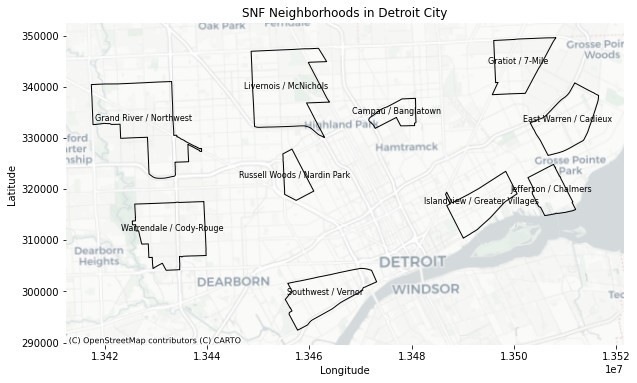

In [42]:
# check the visualization of SNF neighborhoods
# Plot the GeoDataFrame
ax = snf.plot(figsize=(10, 8), color='none', edgecolor='black')

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')
    
# Add background map using contextily
ctx.add_basemap(ax, crs='EPSG:2898', source=ctx.providers.CartoDB.Positron)

# Customize the plot (add title, legend, etc.)
plt.title('SNF Neighborhoods in Detroit City')
plt.box(False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('SNFneighborhoods.jpg')

# Show the plot
plt.show()

### 3. Analysis <a id="viz"></a>

#### a. Population <a id="pop"></a>

In [43]:
#inspect the data
pop2014_.head(2)

,GEOID,geometry,NAME,Population
0,26163524800,"POLYGON ((13450299.502 278352.151, 13449823.16...","Census Tract 5248, Wayne County, Michigan",3135
1,26163521900,"POLYGON ((13472055.602 310118.573, 13471825.55...","Census Tract 5219, Wayne County, Michigan",3044


In [44]:
if (pop2014_['Population'] == 0).any().any():
    print("DataFrame contains zero values")
else:
    print("DataFrame does not contain zero values")

DataFrame contains zero values


We can not remove rows with zero values in population because it will delete the census tract as well and affect the overall map.

In [45]:
# find the maximum value of population to find the scale
# to avoid bias, value scale in 2014 data and in 2022 data should be the same
pop2014_['Population'].max()

5990

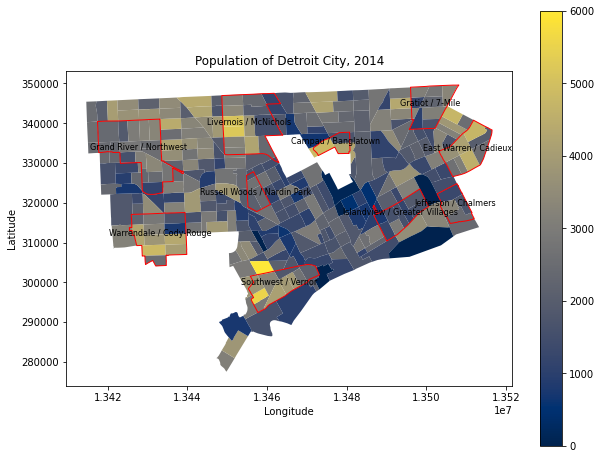

In [46]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
pop2014_.plot(ax=ax, column="Population", cmap='cividis', legend="TRUE", vmax=6000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Population of Detroit City, 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('pop2014.jpg')

# Show the map
plt.show()

In [47]:
#inspect the data
pop2022_.head(2)

,GEOID,geometry,NAME,Population
0,26163500100,"POLYGON ((13506896.601 347570.905, 13507023.94...",Census Tract 5001; Wayne County; Michigan,3622
1,26163500200,"POLYGON ((13504095.532 346792.304, 13504079.97...",Census Tract 5002; Wayne County; Michigan,2549


In [48]:
# find the maximum value of population to find the scale
pop2022_['Population'].max()

5888

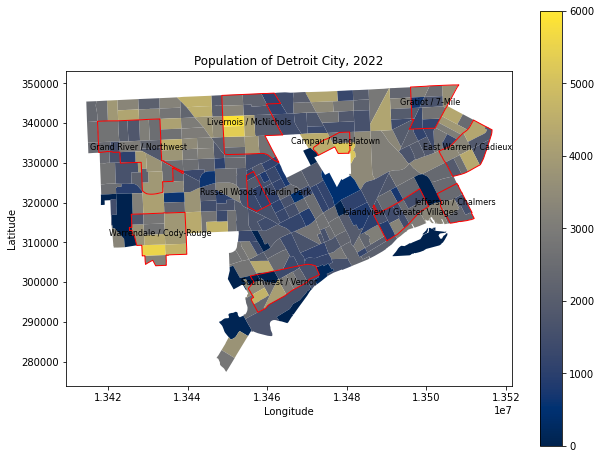

In [49]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
pop2022_.plot(ax=ax, column="Population", cmap='cividis',
              legend="TRUE",vmax=6000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Population of Detroit City, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('pop2022.jpg')

# Show the map
plt.show()

#### b. Population by Race <a id="race"></a>

In [50]:
#inspect the data
race2014_.head(2)

,GEOID,geometry,pop_white0,pop_black0,pop_asian0,pop_other0,pop_latino0,p_white0,p_black0,p_asian0,p_latino0,p_other0
0,26163524800,"POLYGON ((13450299.502 278352.151, 13449823.16...",48,2912,0,36,139,0.015311004784689,0.928867623604466,0,0.0443381180223286,0.0114832535885167
1,26163521900,"POLYGON ((13472055.602 310118.573, 13471825.55...",1036,1608,51,126,223,0.340341655716163,0.528252299605782,0.016754270696452,0.0732588699080158,0.0413929040735874


In [51]:
# find the maximum value of column to find the scale
race2014_['pop_white0'].max()

2391

In [52]:
# find the maximum value of column to find the scale
race2014_['pop_black0'].max()

5003

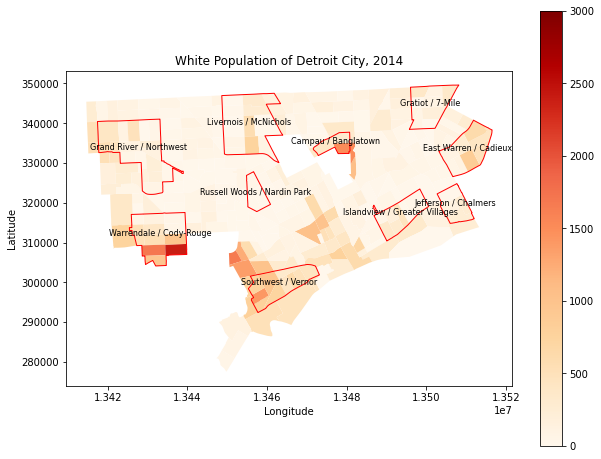

In [53]:
# The visualization represents the two largest population shares: the White and Black communities
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
race2014_.plot(ax=ax, column="pop_white0", cmap='OrRd', legend="TRUE", vmax=3000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('White Population of Detroit City, 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()

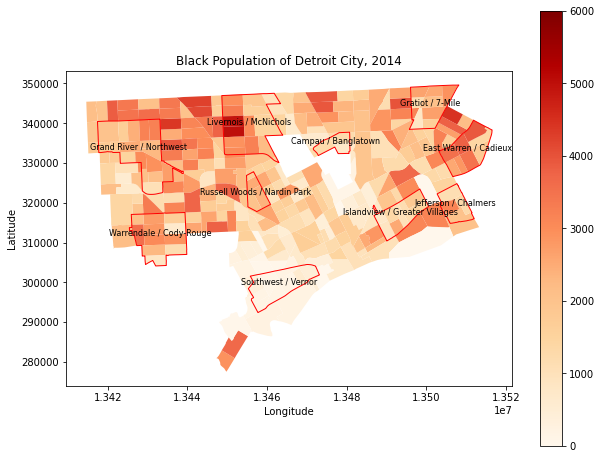

In [54]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
race2014_.plot(ax=ax, column="pop_black0", cmap='OrRd', legend="TRUE", vmax=6000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Black Population of Detroit City, 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()

In [55]:
# find the maximum value of column to find the scale
race2022_['pop_white0'].max()

2936

In [56]:
# find the maximum value of column to find the scale
race2022_['pop_black0'].max()

5572

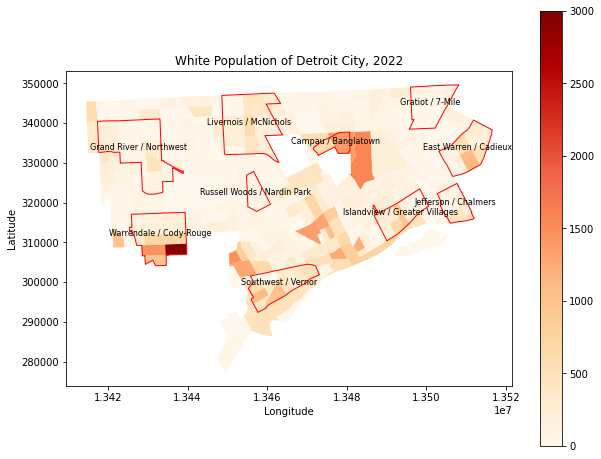

In [57]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
race2022_.plot(ax=ax, column="pop_white0", cmap='OrRd', legend="TRUE", vmax=3000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('White Population of Detroit City, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()

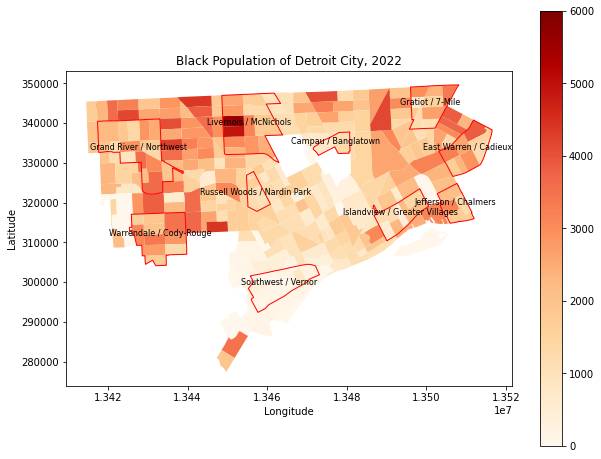

In [58]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
race2022_.plot(ax=ax, column="pop_black0", cmap='OrRd', legend="TRUE", vmax=6000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Black Population of Detroit City, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()

To identify the racial composition in each SNF neighborhood, spatial join between race data and SNF data are conducted.

In [59]:
#overlay the two geodataframes
snf_race14 = gpd.overlay(snf,race2014_, how="intersection")

In [60]:
#check the result
snf_race14.head(2)

,OBJECTID_1,Proj_NAME,Staff_Cont,SNF,Reference,SHAPE_Leng,SHAPE_Area,GEOID,pop_white0,pop_black0,pop_asian0,pop_other0,pop_latino0,p_white0,p_black0,p_asian0,p_latino0,p_other0,geometry
0,1,Campau / Banglatown,East,SNF,https://detroitmi.gov/departments/planning-and...,0.090745,0.000337,26163510600,1509,746,1665,338,0,0.354391733208079,0.175199624236731,0.391028651949272,0,0.0793799906059183,"POLYGON ((13480796.360 334353.480, 13480812.92..."
1,1,Campau / Banglatown,East,SNF,https://detroitmi.gov/departments/planning-and...,0.090745,0.000337,26163510500,378,1252,3068,163,0,0.0777617774120551,0.25756017280395,0.631145854762395,0,0.0335321950216005,"POLYGON ((13472882.815 331871.418, 13472668.30..."


In [61]:
#aggregate each race population data based on SNF neighborhood
snf_race14_ = snf_race14.groupby("Proj_NAME").agg({"pop_white0":'sum',
                                                "pop_black0":'sum',
                                                "pop_asian0":'sum',
                                                "pop_latino0":'sum',
                                                "pop_other0":'sum'}).reset_index()

In [62]:
# inspect the result
snf_race14_

,Proj_NAME,pop_white0,pop_black0,pop_asian0,pop_latino0,pop_other0
0,Campau / Banglatown,2229,3879,4792,0,604
1,East Warren / Cadieux,3066,29197,48,265,788
2,Grand River / Northwest,4294,49808,109,501,1196
3,Gratiot / 7-Mile,2242,46291,311,400,1186
4,Islandview / Greater Villages,2383,25431,176,221,558
5,Jefferson / Chalmers,694,7674,79,95,238
6,Livernois / McNichols,2609,50821,129,365,1425
7,Russell Woods / Nardin Park,271,15383,2,61,300
8,Southwest / Vernor,9845,4234,6,31770,1139
9,Warrendale / Cody-Rouge,9286,34920,202,2411,893


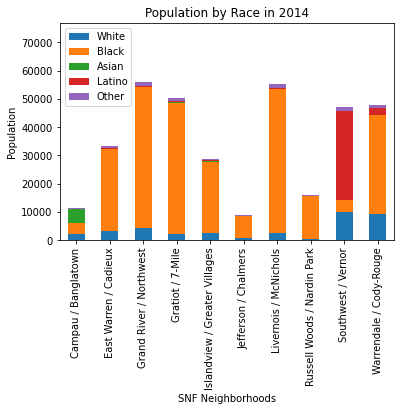

In [63]:
#plot the data to stacked bar chart
snf_race14_.plot(x="Proj_NAME",
                 kind="bar",
                 stacked=True,
                 ylim=(0,77000)) # set the scale to match with other data

label =["White","Black","Asian","Latino","Other"]

# Add labels and title
plt.xlabel('SNF Neighborhoods')
plt.ylabel('Population')
plt.title('Population by Race in 2014')
plt.legend(label)

# Save the data as an image file
plt.savefig('race2014.jpg')

# Show plot
plt.show()

In [64]:
#overlay the two geodataframes
snf_race22 = gpd.overlay(snf,race2022_, how="intersection")

In [65]:
#aggregate each race population data based on SNF neighborhood
snf_race22_ = snf_race22.groupby("Proj_NAME").agg({"pop_white0":'sum',
                                                "pop_black0":'sum',
                                                "pop_asian0":'sum',
                                                "pop_latino0":'sum',
                                                "pop_other0":'sum'}).reset_index()

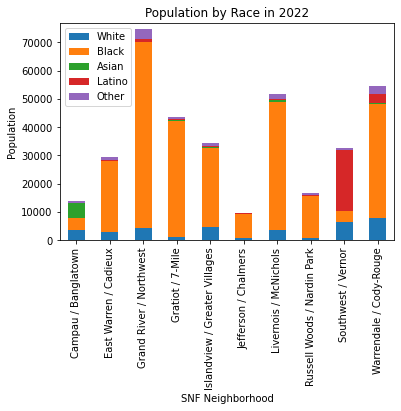

In [66]:
#plot the data to stacked bar chart
snf_race22_.plot(x="Proj_NAME",
                 kind="bar",
                 stacked=True,
                 ylim=(0,77000)) # set the scale to match with other data

label =["White","Black","Asian","Latino","Other"]

# Add labels and title
plt.xlabel('SNF Neighborhood')
plt.ylabel('Population')
plt.title('Population by Race in 2022')
plt.legend(label)

# Save the data as an image file
plt.savefig('race2022.jpg')

# Show plot
plt.show()

#### c. Household Income <a id="income"></a>

In [67]:
#inspect the data
income2014_.head(2)

,GEOID,geometry,Mean income (dollar),Median income (dollar)
0,26163524800,"POLYGON ((13450299.502 278352.151, 13449823.16...",31072,20881
1,26163521900,"POLYGON ((13472055.602 310118.573, 13471825.55...",33846,19478


In [68]:
# find the maximum value of the column to find the scale
# to avoid bias, value scale in 2014 data and in 2022 data should be the same
income2014_['Median income (dollar)'].min()

8733

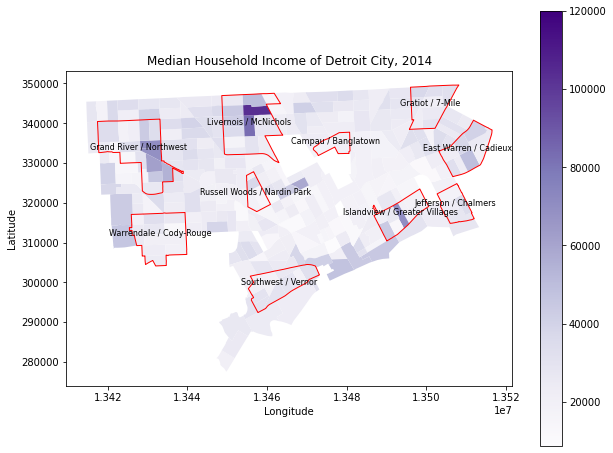

In [69]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
income2014_.plot(ax=ax, column="Median income (dollar)", cmap='Purples',
                 legend="TRUE", vmax=120000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Median Household Income of Detroit City, 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('income2014.jpg')

# Show the map
plt.show()

In [70]:
#inspect the data
income2022_.head(2)

,GEOID,geometry,Mean income (dollar),Median income (dollar)
0,26163500100,"POLYGON ((13506896.601 347570.905, 13507023.94...",57225,44960
1,26163500200,"POLYGON ((13504095.532 346792.304, 13504079.97...",70939,51723


In [71]:
# find the maximum value of the column to find the scale
income2022_['Median income (dollar)'].max()

137987

Because of inflation, 1 dollar in 2014 is similar to 1.24 dollar in 2022. Therefore, with the previous map has the maximum value in 120,000, the maximum value set in 2022 data is 148,000.(https://www.in2013dollars.com/us/inflation/2014?endYear=2022&amount=1)

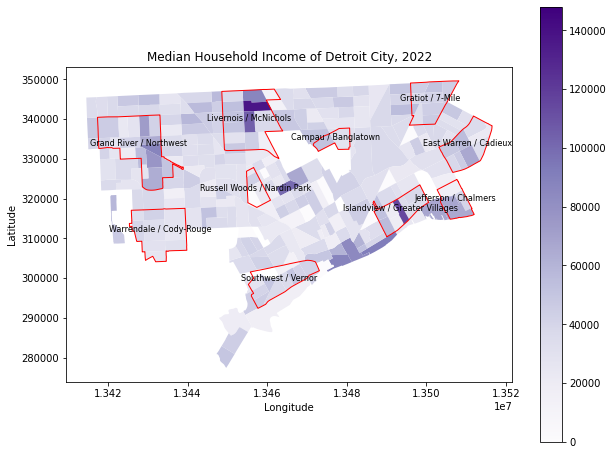

In [72]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
income2022_.plot(ax=ax, column="Median income (dollar)", cmap='Purples',
                 legend="TRUE", vmax=148000)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Median Household Income of Detroit City, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('income2022.jpg')

# Show the map
plt.show()

#### d. Unemployment Rate <a id="employ"></a>

In [73]:
#inspect the data
employ2014_.head(2)

,GEOID,geometry,Employed,LaborForce,Unemployed
0,26163524800,"POLYGON ((13450299.502 278352.151, 13449823.16...",640,923,283
1,26163521900,"POLYGON ((13472055.602 310118.573, 13471825.55...",1209,1540,331


In [74]:
# calculate unemployment rate
employ2014_["unemployment_rate"] = employ2014_["Unemployed"] / employ2014_["LaborForce"]

In [75]:
# find the maximum value of the column to find the scale
# to avoid bias, value scale in 2014 data and in 2022 data should be the same
print(employ2014_['unemployment_rate'].max())

0.5727272727272728


In [76]:
# Replace NaN with a default value
employ2014_["unemployment_rate"] = np.nan_to_num(employ2014_["unemployment_rate"], nan=0)

In [77]:
print(employ2014_['unemployment_rate'].unique())

[0.30660888 0.21493506 0.19733333 0.25766871 0.11538462 0.21818182
 0.16630901 0.         0.0181311  0.15283843 0.21052632 0.1303781
 0.24793388 0.32816537 0.23802915 0.30306604 0.15254237 0.14564831
 0.42657343 0.40512821 0.47863248 0.08826879 0.29963235 0.11789773
 0.31146107 0.2469352  0.40773286 0.17024426 0.37620579 0.2749004
 0.30732861 0.36986301 0.215311   0.25763126 0.14563107 0.19712526
 0.1377858  0.30144033 0.55566038 0.31238095 0.23135755 0.17276423
 0.30911901 0.29933481 0.2522686  0.41257367 0.43687375 0.26401703
 0.47959184 0.27935943 0.0462963  0.26245211 0.19318972 0.29824561
 0.41694915 0.32815965 0.33562428 0.34656085 0.26666667 0.34390863
 0.24878523 0.17167052 0.21624174 0.39534884 0.33078603 0.38999206
 0.37352626 0.35845411 0.41912799 0.27408056 0.40584695 0.22016807
 0.27761836 0.22402827 0.3204983  0.39236479 0.3447205  0.1611479
 0.26582278 0.26932367 0.22572509 0.3551963  0.23207547 0.29185868
 0.27860995 0.33855799 0.22294372 0.10351201 0.25618375 0.2908704

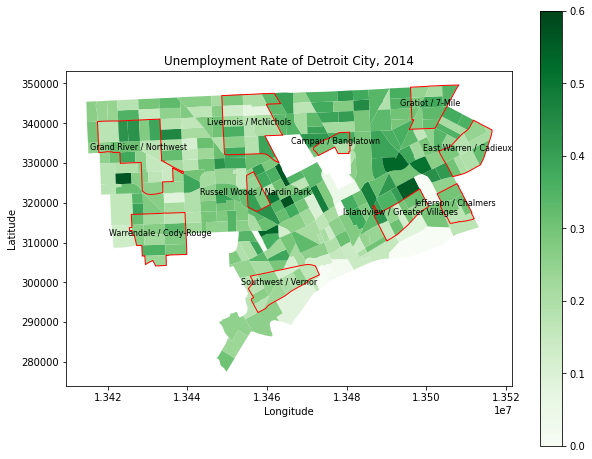

In [78]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
employ2014_.plot(ax=ax, column="unemployment_rate", cmap='Greens', legend="TRUE",
                 vmax=0.6)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Unemployment Rate of Detroit City, 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('unemployment2014.jpg')

# Show the map
plt.show()

In [79]:
#inspect the data
employ2022_.head(2)

,GEOID,geometry,Employed,LaborForce,Unemployed
0,26163500100,"POLYGON ((13506896.601 347570.905, 13507023.94...",1339,1626,287
1,26163500200,"POLYGON ((13504095.532 346792.304, 13504079.97...",1089,1507,418


In [80]:
# calculate unemployment rate
employ2022_["unemployment_rate"] = employ2022_["Unemployed"] / employ2022_["LaborForce"]

In [81]:
# find the maximum value of the column to find the scale
employ2022_['unemployment_rate'].max()

0.48878923766816146

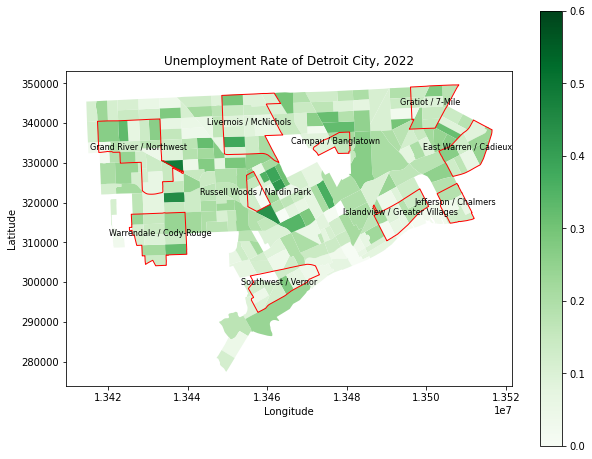

In [82]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
employ2022_.plot(ax=ax, column="unemployment_rate", cmap='Greens', legend="TRUE",
                 vmax=0.6)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Unemployment Rate of Detroit City, 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('unemployment2022.jpg')

# Show the map
plt.show()

#### e. Building Vacancy <a id="vacant"></a>

In [83]:
#inspect the data
vacant2014.head(2)

,GEOID10,Pct_VeryLi,geometry
0,26163524800,6.168080,"POLYGON ((13451859.752 280937.886, 13451480.46..."
1,26163521900,5.175601,"POLYGON ((13473279.177 313045.760, 13473462.39..."


In [84]:
# rename ID column to match with other data
vacant2014 = vacant2014.rename(columns={'GEOID10': 'GEOID'})

In [85]:
# find the maximum value of the column to find the scale
# to avoid bias, value scale in 2014 data and in 2022 data should be the same
vacant2014['Pct_VeryLi'].max()

38.8888888888889

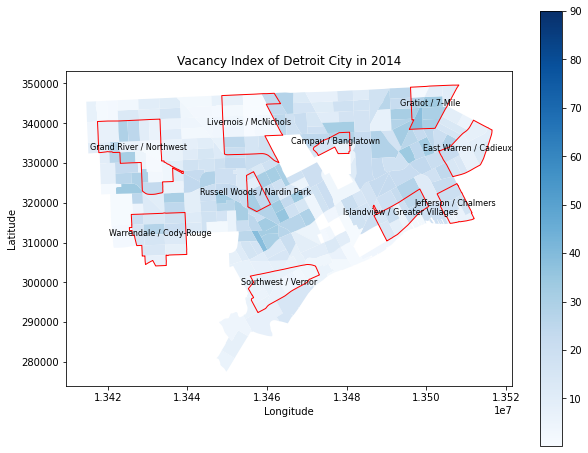

In [86]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
vacant2014.plot(ax=ax, column='Pct_VeryLi', cmap="Blues", legend="true",
             vmax=90)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Vacancy Index of Detroit City in 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Save the map as an image file
plt.savefig('vacancy2014.jpg')

# Show the map
plt.show()

In [87]:
#inspect the data
vacant2023.head(5)

,property_1,geometry
0,COMMERCIAL VACANT,"POLYGON ((13478376.504 304890.930, 13478464.09..."
1,COMMERCIAL VACANT,"POLYGON ((13478452.818 304761.197, 13478562.97..."
2,COMMERCIAL,"POLYGON ((13479117.285 305162.088, 13479177.34..."
3,COMMERCIAL,"POLYGON ((13479133.487 304712.942, 13479180.90..."
4,COMMERCIAL,"POLYGON ((13479180.905 304741.845, 13479267.17..."


In [88]:
# filter vacant data based on vacancy status
filtered_vacant23 = vacant2023[vacant2023['property_1'].isin(['COMMERCIAL VACANT',
                                                      'INDUSTRIAL VACANT','RESIDENTIAL VACANT'])]

In [89]:
# check the result
filtered_vacant23.head(2)

,property_1,geometry
0,COMMERCIAL VACANT,"POLYGON ((13478376.504 304890.930, 13478464.09..."
1,COMMERCIAL VACANT,"POLYGON ((13478452.818 304761.197, 13478562.97..."


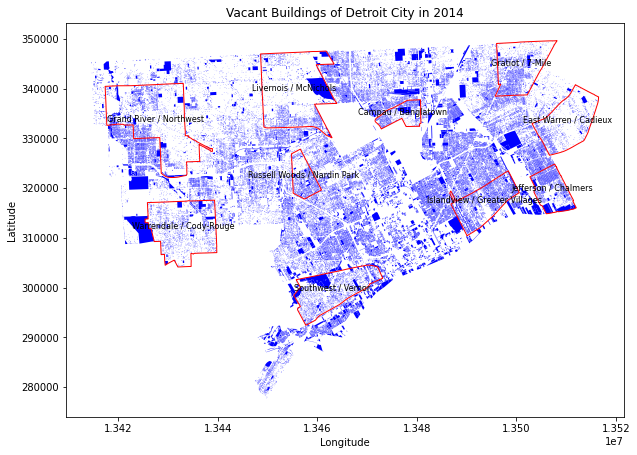

In [90]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
filtered_vacant23.plot(ax=ax, color='blue', legend='true')

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', label='Proj_NAME', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Vacant Buildings of Detroit City in 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the map
plt.show()

This map can not be compared with the vacancy index map in 2014. Therefore, some analysis should be taken to calculate the vacancy index in 2023. The general formula for vacancy index is total vacant buildings divided by total buildings in the same area which is census tract level in this case.

In [91]:
# combine vacant 2023 data with census tract 2020 data
vacant2023_ = gpd.overlay(tract_detroit2020,vacant2023, how="intersection")

In [92]:
# calculate the total building structure for each census tract (GEOID) and assigned to new column
vacant2023_['totalstr'] = vacant2023_.groupby('GEOID')['property_1'].transform('count')

In [93]:
# inspect the result
vacant2023_

,GEOID,property_1,geometry,totalstr
0,26163500100,RESIDENTIAL,"POLYGON ((13504324.411 346971.740, 13504363.56...",1642
1,26163500100,RESIDENTIAL,"POLYGON ((13504290.546 349256.355, 13504330.36...",1642
2,26163500100,RESIDENTIAL,"POLYGON ((13504314.027 348277.089, 13504354.17...",1642
3,26163500100,RESIDENTIAL,"POLYGON ((13504301.776 349073.740, 13504341.59...",1642
4,26163500100,RESIDENTIAL,"POLYGON ((13504303.767 348939.693, 13504343.91...",1642
...,...,...,...,...
380979,26163985900,INDUSTRIAL,"POLYGON ((13478980.014 317914.159, 13479098.13...",50
380980,26163985900,COMMERCIAL VACANT,"POLYGON ((13478748.827 318033.988, 13478819.33...",50
380981,26163985900,INDUSTRIAL VACANT,"POLYGON ((13478886.891 318104.462, 13478917.35...",50
380982,26163985900,INDUSTRIAL,"POLYGON ((13478917.352 318044.787, 13478957.40...",50


In [94]:
# extract only the total building information and GEOID
vacant2023__ = vacant2023_.groupby("GEOID").agg({"totalstr":"first"}).reset_index()

In [95]:
#inspect the result
vacant2023__

,GEOID,totalstr
0,26163500100,1642
1,26163500200,1297
2,26163500300,1564
3,26163500400,1633
4,26163500500,1292
...,...,...
271,26163985200,37
272,26163985300,181
273,26163985500,1
274,26163985800,6


In [96]:
# combine vacant 2023 data with census tract 2020 data
filtered_vacant23_ = gpd.overlay(tract_detroit2020,filtered_vacant23, how="intersection")

In [97]:
# calculate the total vacant building for each census tract (GEOID) and assigned to new column
filtered_vacant23_['totalvacant'] = filtered_vacant23_.groupby('GEOID')[
    'property_1'].transform('count')

In [98]:
# inspect the result
filtered_vacant23_

,GEOID,property_1,geometry,totalvacant
0,26163500100,RESIDENTIAL VACANT,"POLYGON ((13504325.564 347957.259, 13504365.71...",152
1,26163500100,RESIDENTIAL VACANT,"POLYGON ((13504926.887 347349.226, 13504967.03...",152
2,26163500100,RESIDENTIAL VACANT,"POLYGON ((13504594.066 347468.161, 13504630.89...",152
3,26163500100,RESIDENTIAL VACANT,"POLYGON ((13504594.166 347146.265, 13504634.31...",152
4,26163500100,RESIDENTIAL VACANT,"POLYGON ((13504094.962 347948.302, 13504131.79...",152
...,...,...,...,...
133849,26163985900,INDUSTRIAL VACANT,"POLYGON ((13477412.316 319056.618, 13477549.34...",20
133850,26163985900,INDUSTRIAL VACANT,"POLYGON ((13477562.289 318773.261, 13477878.82...",20
133851,26163985900,COMMERCIAL VACANT,"POLYGON ((13477627.321 318647.509, 13477630.63...",20
133852,26163985900,COMMERCIAL VACANT,"POLYGON ((13478748.827 318033.988, 13478819.33...",20


In [99]:
# extract only the vacant building information and GEOID
filtered_vacant23__ = filtered_vacant23_.groupby("GEOID").agg({"totalvacant":"first"}).reset_index()

In [100]:
# inspect the result
filtered_vacant23__

,GEOID,totalvacant
0,26163500100,152
1,26163500200,166
2,26163500300,477
3,26163500400,1057
4,26163500500,525
...,...,...
269,26163985100,159
270,26163985200,16
271,26163985300,101
272,26163985800,3


The difference of total rows between total building structure and total vacant building indicates some census tracts has no vacant buildings.

In [101]:
# join the total building, total vacant, and GEOID
vacant23_final = filtered_vacant23__.merge(vacant2023__, on='GEOID', how='inner')

In [102]:
# calculate vacancy index and assign to new column
vacant23_final['index'] = (vacant23_final['totalvacant']/vacant23_final['totalstr'])*100

In [103]:
# inspect the result
vacant23_final

,GEOID,totalvacant,totalstr,index
0,26163500100,152,1642,9.257004
1,26163500200,166,1297,12.798766
2,26163500300,477,1564,30.498721
3,26163500400,1057,1633,64.727495
4,26163500500,525,1292,40.634675
...,...,...,...,...
269,26163985100,159,211,75.355450
270,26163985200,16,37,43.243243
271,26163985300,101,181,55.801105
272,26163985800,3,6,50.000000


In [104]:
# ensure the data type
print(vacant23_final['index'].dtype)

float64


In [105]:
# find the maximum value of the column to find the scale
# to avoid bias, value scale in 2014 data and in 2022 data should be the same
print(vacant23_final['index'].max())

87.32394366197182


In [106]:
# join vacant 2023 final data with census tract 2020 data to get the geometry
vacant23_final_ = tract_detroit2020.merge(vacant23_final, on='GEOID', how='inner')

In [107]:
# inspect the result
vacant23_final_

,GEOID,geometry,totalvacant,totalstr,index
0,26163500100,"POLYGON ((13506896.601 347570.905, 13507023.94...",152,1642,9.257004
1,26163500200,"POLYGON ((13504095.532 346792.304, 13504079.97...",166,1297,12.798766
2,26163500300,"POLYGON ((13504200.997 344139.637, 13504188.33...",477,1564,30.498721
3,26163500400,"POLYGON ((13499043.548 340941.593, 13499029.83...",1057,1633,64.727495
4,26163500500,"POLYGON ((13503421.584 340974.292, 13503261.67...",525,1292,40.634675
...,...,...,...,...,...
269,26163985100,"POLYGON ((13475802.544 327218.694, 13475649.28...",159,211,75.355450
270,26163985200,"POLYGON ((13501258.189 325180.420, 13501195.85...",16,37,43.243243
271,26163985300,"POLYGON ((13475526.444 304427.921, 13475351.30...",101,181,55.801105
272,26163985800,"POLYGON ((13426225.191 317082.988, 13426220.46...",3,6,50.000000


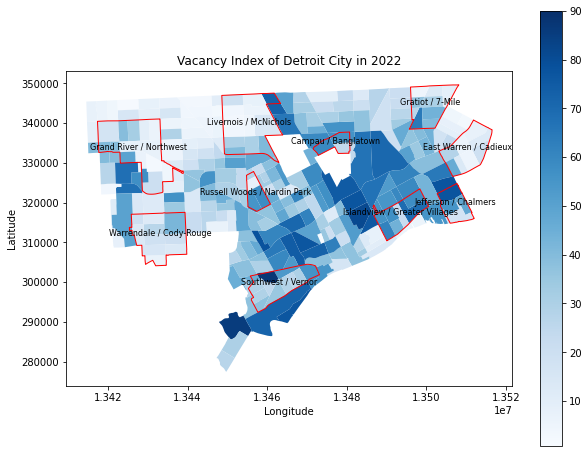

In [108]:
# Plot both GeoDataFrames on the same map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first GeoDataFrame
vacant23_final_.plot(ax=ax, column='index', cmap='Blues', legend='true',
                    vmax=90)

# Plot the second GeoDataFrame
snf.plot(ax=ax, color='none', edgecolor='red', legend="TRUE")

# Add labels to the map
for idx, row in snf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['Proj_NAME'], fontsize=8, ha='center')

# add title to the map
plt.title('Vacancy Index of Detroit City in 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the map as an image file
plt.savefig('vacancy2022.jpg')

# Show the map
plt.show()

### 4. Regression Analysis <a id="reg"></a>

Regression analysis performed as additional analysis to identify the relationship between the variables. The result provides more understanding about the urban decay in Detroit not just in one variable but also the relationship between variables.

In [168]:
# combine all the variable data and drop geometry to simplify calculation
merged2014 = vacant2014.merge(pop2014_,on="GEOID").merge(
    race2014_,on="GEOID").merge(
    income2014_,on="GEOID").merge(
    employ2014_,on="GEOID").drop(
    columns="geometry").drop(
    columns="geometry_x").drop(
    columns="geometry_y")

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.8.0/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geometry_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [171]:
# inspect the result
merged2014.head(2)

,GEOID,Pct_VeryLi,NAME,Population,pop_white0,pop_black0,pop_asian0,pop_other0,pop_latino0,p_white0,p_black0,p_asian0,p_latino0,p_other0,Mean income (dollar),Median income (dollar),Employed,LaborForce,Unemployed,unemployment_rate
0,26163524800,6.168080,"Census Tract 5248, Wayne County, Michigan",3135,48,2912,0,36,139,0.015311004784689,0.928867623604466,0,0.0443381180223286,0.0114832535885167,31072,20881,640,923,283,0.306609
1,26163521900,5.175601,"Census Tract 5219, Wayne County, Michigan",3044,1036,1608,51,126,223,0.340341655716163,0.528252299605782,0.016754270696452,0.0732588699080158,0.0413929040735874,33846,19478,1209,1540,331,0.214935


In [172]:
# Check for NaN or infinity values
if merged2014.isnull().values.any() or not merged2014.isfinite().all().all():
    # Handle NaN or infinity values
    merged2014.fillna(0, inplace=True)  # Replace NaN with 0
    merged2014 = merged2014.replace([np.inf, -np.inf], 0)  # Replace infinity with 0

In [173]:
def perform_multiple_regression(data, column_names_):
    results = {}
    for column_name in column_names:
        x = data['Pct_VeryLi'].values.reshape((-1, 1))
        y = data[column_name]
        model = LinearRegression()
        model.fit(x, y)
        r_squared = model.score(x, y)
        results[column_name] = {'coefficients': model.coef_,
                                'r_squared': r_squared}
    return results

In [174]:
# list column names to be read and their output names
column_names = ['Population',
                'pop_white0',
                'pop_black0',
                'Median income (dollar)',
                'unemployment_rate']

results = perform_multiple_regression(merged2014, column_names)

# Print the results
for column_name, result in results.items():
    print(f"Regression results for {column_name}:")
    print("Coefficients:", result['coefficients'])
    print("R-squared:", result['r_squared'])
    print()

Regression results for Population:
Coefficients: [-41.91430194]
R-squared: 0.13795103164124733

Regression results for pop_white0:
Coefficients: [-10.91458876]
R-squared: 0.10650780198934451

Regression results for pop_black0:
Coefficients: [-16.38741764]
R-squared: 0.021675102306864424

Regression results for Median income (dollar):
Coefficients: [-519.73528442]
R-squared: 0.195814968084439

Regression results for unemployment_rate:
Coefficients: [0.0049863]
R-squared: 0.24572543576762762



In [120]:
# combine all the variable data and drop geometry to simplify calculation
merged2022 = vacant23_final_.merge(pop2022_,on="GEOID").merge(
    race2022_,on="GEOID").merge(
    income2022_,on="GEOID").merge(
    employ2022_,on="GEOID").drop(
    columns="geometry").drop(
    columns="geometry_x").drop(
    columns="geometry_y")

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.8.0/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: Passing 'suffixes' which cause duplicate columns {'geometry_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [121]:
# inspect the result
merged2022.head(2)

,GEOID,totalvacant,totalstr,index,NAME,Population,pop_white0,pop_black0,pop_asian0,pop_other0,...,p_black0,p_asian0,p_latino0,p_other0,Mean income (dollar),Median income (dollar),Employed,LaborForce,Unemployed,unemployment_rate
0,26163500100,152,1642,9.257004,Census Tract 5001; Wayne County; Michigan,3622,122,3354,0,128,...,0.926007730535616,0,0.00496963003865268,0.0353395913859746,57225,44960,1339,1626,287,0.176507
1,26163500200,166,1297,12.798766,Census Tract 5002; Wayne County; Michigan,2549,71,2369,0,55,...,0.929384072185171,0,0.0211847783444488,0.0215770890545312,70939,51723,1089,1507,418,0.277372


In [122]:
def perform_multiple_regression2(data, column_names):
    results = {}
    for column_name in column_names:
        X = data['index'].values.reshape((-1, 1))
        y = data[column_name]
        model = LinearRegression()
        model.fit(X, y)
        r_squared = model.score(X, y)
        results[column_name] = {'coefficients': model.coef_,
                                'r_squared': r_squared}
    return results

In [123]:
# use the function for merged2022 data
results = perform_multiple_regression2(merged2022, column_names)

# Print the results
for column_name, result in results.items():
    print(f"Regression results for {column_name}:")
    print("Coefficients:", result['coefficients'])
    print("R-squared:", result['r_squared'])
    print()

Regression results for Population:
Coefficients: [-28.93274234]
R-squared: 0.3092073140052549

Regression results for pop_white0:
Coefficients: [-0.89283868]
R-squared: 0.0025944159798840793

Regression results for pop_black0:
Coefficients: [-28.52947575]
R-squared: 0.3072055994482461

Regression results for Median income (dollar):
Coefficients: [-334.69516267]
R-squared: 0.14918416075012864

Regression results for unemployment_rate:
Coefficients: [0.00061087]
R-squared: 0.020586971056143155



### 5. Conclusion <a id="conclusion"></a>

The changes are found in demographic, economic, and physical aspects in Detroit City as well as in SNF Neighborhoods. Total population is relatively decrease in entire Detroit City but some SNF neighborhoods exhibit a slight increase in population which are Warrendale, Livernois, and Campau. In racial composition, Black residents appeared to dominate and the increase in black communities occurs nearly in entire neighborhoods, while white residents tend to decrease except in Campau, Islandview, and Livernois. The median household income is increasing nearly in whole Detroit City. Of the ten SNF neighborhoods, the most significant increase can be found in the Jefferson neighborhood.

Conversely, the unemployment rate appeared to decrease in 2022 where a lower unemployment rate indicates that fewer people are without jobs. No particular neighborhood shows a noticeable or significant change in this variable. In physical aspect, the vacancy index has significantly increased from 2014 to 2022 in entire parts of Detroit City. The most visible rise can be found in the center and east parts of Detroit where more than 50% of their structures are vacant. Islandview and Jefferson's neighborhood are two noticeable places in this variable.

The additional analysis, regression, showed that all variables have lower significance to building vacancy. However, the direction of the relationship between population, white race, black race, and median household income is found to be negative with building vacancy, while the unemployment rate has a positive relationship.